In [1]:
import scanpy as sc
import pandas as pd
import pickle
import time
import anndata
import sklearn.metrics
import statistics
import graph_tool.all as gt
%matplotlib notebook
%pylab

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('beta_parameter/adata_10x.h5ad')

In [3]:
g=pickle.load(open('beta_parameter/g.pkl','rb'))

In [4]:
a=time.time()
state1=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state2=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state3=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
b=time.time()
b-a

299.3650302886963

In [5]:
pickle.dump(state1,open('new_alg_sets/10x/state1.pkl','wb'),2)
pickle.dump(state2,open('new_alg_sets/10x/state2.pkl','wb'),2)
pickle.dump(state3,open('new_alg_sets/10x/state3.pkl','wb'),2)

<IPython.core.display.Javascript object>


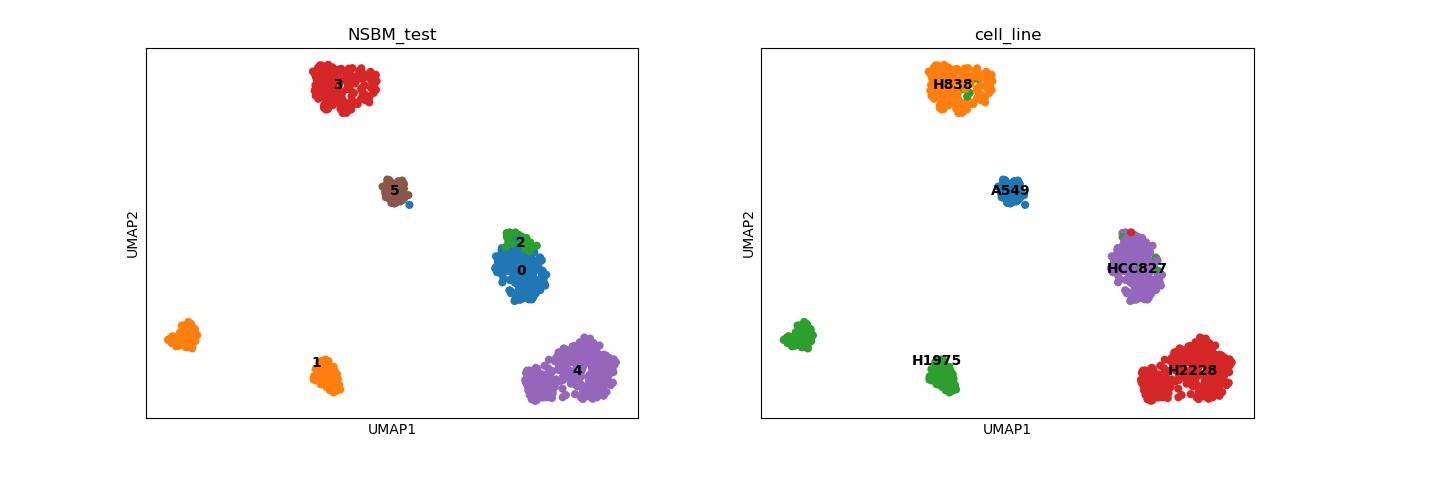

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,3,0,165
1,0,0,127,0,0
2,0,0,1,1,23
3,0,176,7,0,0
4,0,0,0,295,0
5,61,0,0,0,0


In [8]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state3.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

##### scelgo il grafo peggiore e porto avanti l'analisi (sono tutti simili, quindi continuo con state1)

In [9]:
state=pickle.load(open('new_alg_sets/10x/state1.pkl','rb'))

# Anneal come ora (epsilon = 0.001, niter=10, nbreaks=2)

In [10]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

astate=state.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(astate,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0.001,mcmc_args=dict(niter=10)))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('new_alg_sets/10x/astate_e001_nm2_nit10.pkl','wb'),2)
astate

1106.5955891609192


<NestedBlockState object, with base <BlockState object with 157 blocks (91 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges, 1 internal edge property, at 0x7ffa12115710>, at 0x7ffa12651f90>, and 10 levels of sizes [(860, 91), (91, 22), (22, 6), (6, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ffa1259f990>

<IPython.core.display.Javascript object>


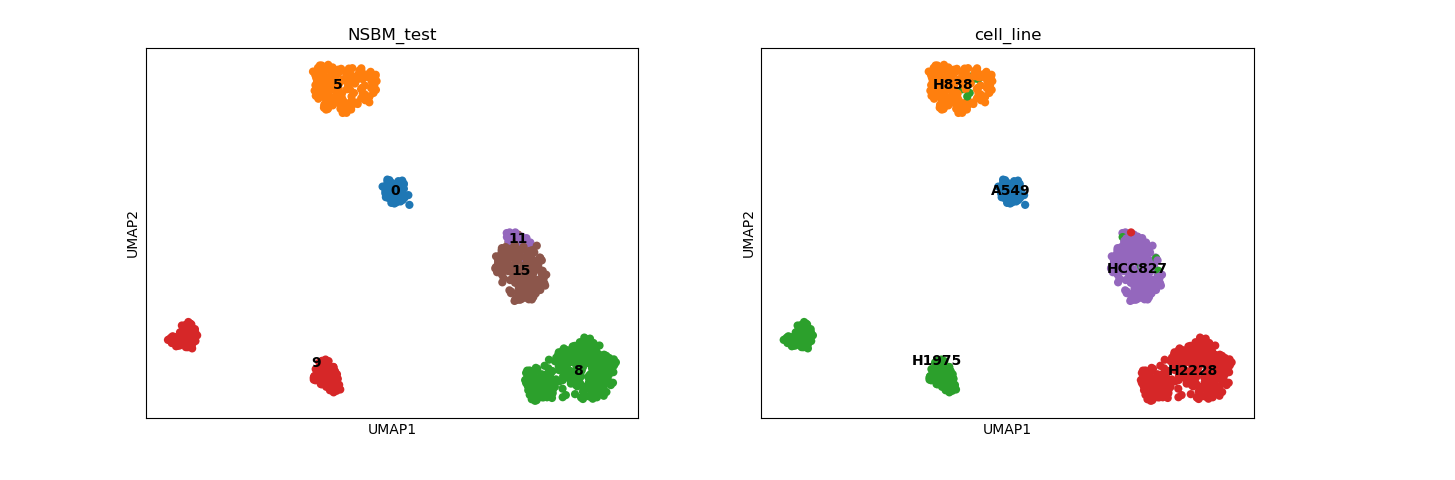

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,62,0,0,0,0
5,0,176,7,0,0
8,0,0,0,295,0
9,0,0,127,0,0
11,0,0,1,1,18
15,0,0,3,0,170


In [11]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(astate.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

#### il grafo è venuto bene, ma ci ha messo 1100 secondi, per un subset di cellule piccolissimo
# sweep and Anneal niter=0, epsilon=0, nbreaks=2

In [21]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
a=time.time()
states=state.copy(bs=bs, sampling=True)
states.mcmc_sweep(niter=10000)
b=time.time()
bs = states.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
astate=states.copy(bs=bs, sampling=True)

gt.mcmc_anneal(astate,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0.001))
c=time.time()
d=b-a
e=c-b
print(d,e,d+e)
pickle.dump(state,open('new_alg_sets/10x/astate_e001_nm2_postsweep.pkl','wb'),2)
astate

33.40305519104004 113.90907526016235 147.3121304512024


<NestedBlockState object, with base <BlockState object with 157 blocks (95 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges, 1 internal edge property, at 0x7ffa12115710>, at 0x7ffa11ea7550>, and 10 levels of sizes [(860, 95), (95, 22), (22, 7), (7, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ffa12add350>

<IPython.core.display.Javascript object>


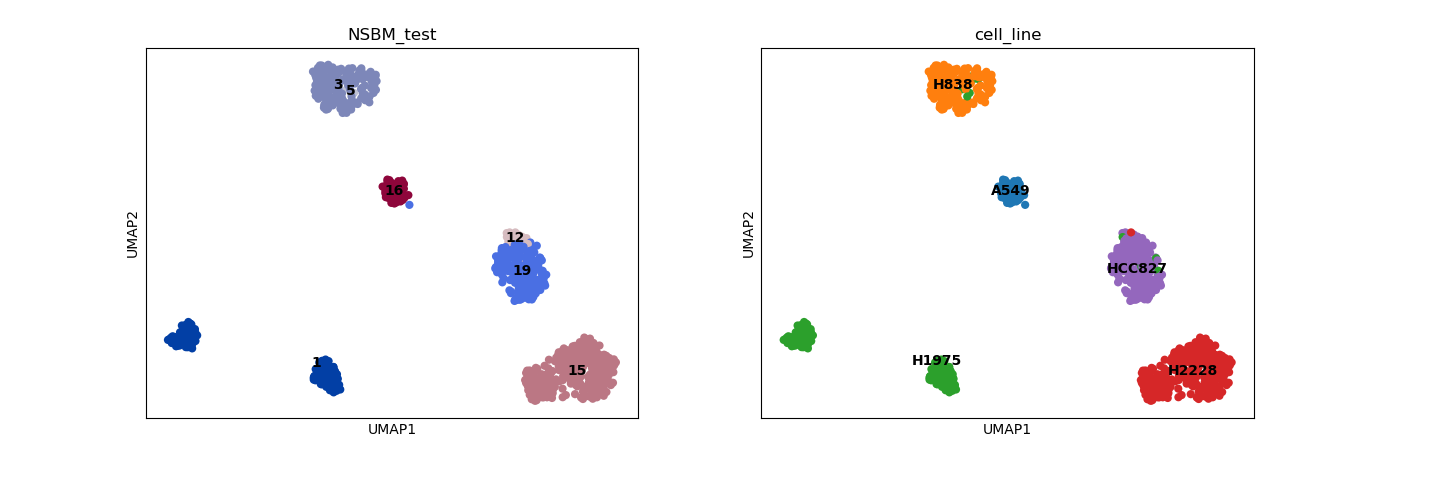

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,0,0,127,0,0
3,0,176,5,0,0
5,0,0,2,0,0
12,0,0,1,1,20
15,0,0,0,295,0
16,61,0,0,0,0
19,1,0,3,0,168


In [22]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(astate.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)